## WMEnv updated observations

This section uses `cls.WMEnv` with angular FOV (front/left/right) and fixed-length observation vectors to validate trajectories and observations.



# Trajectory tests and visualization

This notebook:
- Creates trajectories in the `cls.SquareEnvironment`
- Plots 2D paths on the grid
- Visualizes sensory inputs per step as a timeline

Assumptions:
- Vector actions `(dx, dy)` in `{-1, 0, 1}`; movement allows partial steps at boundaries.
- Field of view width increases with distance to the facing wall by default but is configurable.



In [1]:
import os
import sys
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt

# Ensure project root on sys.path for local imports when running directly
try:
    HERE = os.path.dirname(os.path.abspath(__file__))  # type: ignore[name-defined]
except NameError:
    HERE = os.getcwd()
PROJECT_ROOT = os.path.abspath(os.path.join(HERE, ".."))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from cls import WMEnv


def run_trajectory(env: WMEnv, actions: List[Tuple[int, int]]):
    """Run a sequence of vector actions and collect (pos, goal, sense) per step.

    Returns:
    - positions: list of (x, y)
    - goal: final goal position (constant)
    - senses: list of sensory inputs (variable-length slices)
    """
    positions = []
    senses = []

    cur, goal, sense = env.reset()
    positions.append(cur)
    senses.append(sense)

    for a in actions:
        cur, goal, sense = env.step(a)
        positions.append(cur)
        senses.append(sense)

    return positions, goal, senses


def plot_grid_path(positions: List[Tuple[int, int]], goal: Tuple[int, int], size: int, title: str = "Path"):
    """Plot the grid, start, goal, and path."""
    xs = [p[0] for p in positions]
    ys = [p[1] for p in positions]

    plt.figure(figsize=(5, 5))
    # Grid lines
    for i in range(size + 1):
        plt.plot([0, size - 1], [i - 0.5, i - 0.5], color="#eeeeee", linewidth=1)
        plt.plot([i - 0.5, i - 0.5], [0, size - 1], color="#eeeeee", linewidth=1)

    # Path
    plt.plot(xs, ys, marker="o", color="tab:blue")
    plt.scatter([xs[0]], [ys[0]], color="green", s=80, label="start")
    plt.scatter([goal[0]], [goal[1]], color="red", s=80, label="goal")
    plt.xlim(-0.5, size - 0.5)
    plt.ylim(-0.5, size - 0.5)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.xticks(range(size))
    plt.yticks(range(size))
    plt.grid(False)
    plt.legend(loc="best")
    plt.title(title)
    plt.show()


def plot_sensory_inputs(senses: List[List[int]], title: str = "Observations"):
    """Plot sensory inputs as a heatmap over time.

    Each row is a time step, each column the index along the observed wall slice; since
    widths vary, we center-pad to the maximum width per episode with NaN and mask it.
    """
    max_w = max(len(s) for s in senses)
    if max_w == 0:
        return

    arr = np.full((len(senses), max_w), np.nan)
    for t, s in enumerate(senses):
        w = len(s)
        lo = (max_w - w) // 2
        arr[t, lo:lo + w] = s

    plt.figure(figsize=(6, max(2, len(senses) * 0.3)))
    cmap = plt.get_cmap('viridis')
    plt.imshow(arr, aspect='auto', interpolation='nearest', cmap=cmap)
    plt.colorbar(label='wall pattern value')
    plt.xlabel('relative index in visible slice (centered)')
    plt.ylabel('time step')
    plt.title(title)
    plt.show()



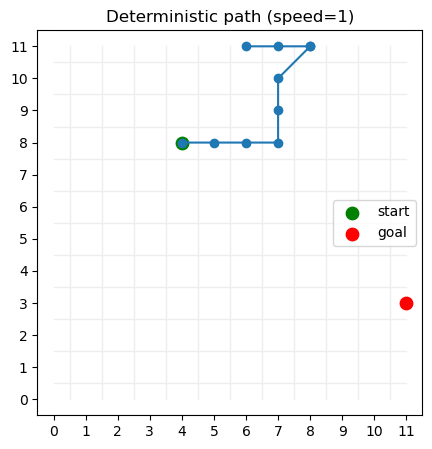

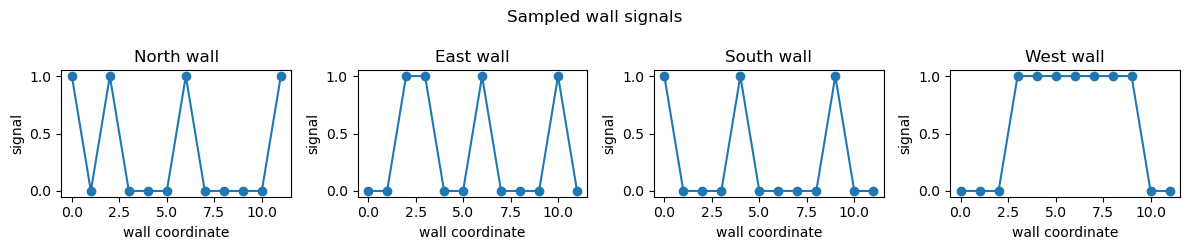

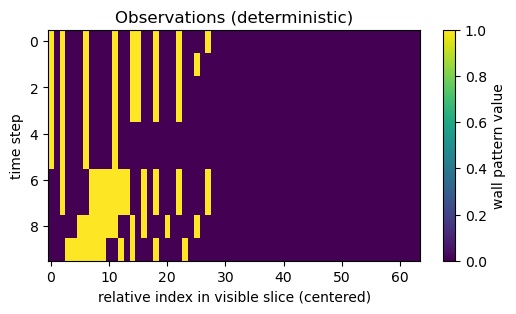

In [8]:
# Deterministic trajectory (WMEnv with angular FOV + fixed-length observations)
env = WMEnv(size=12, speed=1, seed=7, observation_size=64, fov_deg=120.0)

actions = [
    (1, 0), (1, 0), (1, 0),  # move east
    (0, 1), (0, 1),          # move north
    (1, 1),                  # diagonal NE
    (0, 0),                  # stay
    (-1, 0), (-1, 0),        # west
]

positions, goal, senses = run_trajectory(env, actions)
plot_grid_path(positions, goal, env.size, title="Deterministic path (speed=1)")

# Plot sampled continuous wall signals (front/left/right signals are derived from these)
walls = [env._walls.north, env._walls.east, env._walls.south, env._walls.west]
names = ["North wall", "East wall", "South wall", "West wall"]

fig, axes = plt.subplots(1, 4, figsize=(12, 2.5))
for ax, wall, name in zip(axes, walls, names):
    ax.plot(wall, marker="o")
    ax.set_title(name)
    ax.set_xlabel("wall coordinate")
    ax.set_ylabel("signal")
fig.suptitle("Sampled wall signals")
plt.tight_layout()
plt.show()

plot_sensory_inputs(senses, title="Observations (deterministic)")

All observation consistency checks passed.


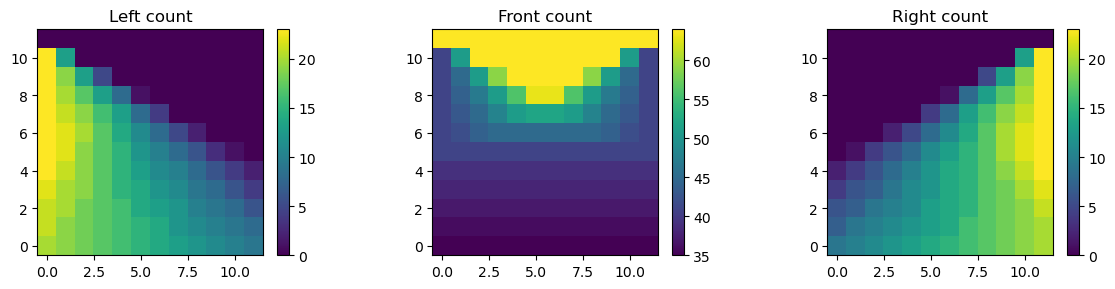

In [9]:

import numpy as np
from typing import Tuple, List
from cls import WMEnv

def _counts_from_geometry(size: int, pos: Tuple[int,int], heading: Tuple[int,int], fov_deg: float, observation_size: int):
    x, y = pos
    n, s, e, w = (size - 1) - y, y, (size - 1) - x, x

    if heading == (0, 1):   fdist, ldist, rdist = n, w, e
    elif heading == (0, -1): fdist, ldist, rdist = s, e, w
    elif heading == (1, 0):  fdist, ldist, rdist = e, n, s
    else:                    fdist, ldist, rdist = w, s, n

    half = np.deg2rad(fov_deg / 2.0)
    comp = np.deg2rad(90.0 - fov_deg / 2.0)

    y_extent = fdist * np.tan(half)
    left_from_front  = (y_extent - ldist) * np.tan(comp) if ldist < y_extent else None
    right_from_front = (y_extent - rdist) * np.tan(comp) if rdist < y_extent else None

    front_length = max(0.0, y_extent)
    left_length  = abs(left_from_front)  if left_from_front  is not None else 0.0
    right_length = abs(right_from_front) if right_from_front is not None else 0.0
    vision_length = front_length + left_length + right_length

    if vision_length <= 0:
        front_count, left_count, right_count = observation_size, 0, 0
    else:
        front_count = int(round(observation_size * (front_length / vision_length)))
        left_count  = int(round(observation_size * (left_length  / vision_length)))
        right_count = observation_size - front_count - left_count
        if right_count < 0:
            right_count = 0
    return left_count, front_count, right_count

def _slice_centered(pattern: List[int], center_idx: int, count: int, size: int) -> List[int]:
    if count <= 0:
        return []
    half = (count - 1) // 2
    lo = max(0, center_idx - half)
    hi = min(size, lo + count)
    if hi - lo < count:
        lo = max(0, hi - count)
    return pattern[lo:hi]

def _walls_and_centers(env: WMEnv, pos: Tuple[int,int], heading: Tuple[int,int]):
    x, y = pos
    if heading == (0, 1):   # north
        return (env._walls.west, y), (env._walls.north, x), (env._walls.east, y)
    if heading == (0, -1):  # south
        return (env._walls.east, y), (env._walls.south, x), (env._walls.west, y)
    if heading == (1, 0):   # east
        return (env._walls.north, x), (env._walls.east, y), (env._walls.south, x)
    # west
    return (env._walls.south, x), (env._walls.west, y), (env._walls.north, x)

def assert_obs_matches(env: WMEnv, pos: Tuple[int,int], heading: Tuple[int,int]):
    size = env.size
    lc, fc, rc = _counts_from_geometry(size, pos, heading, env._fov_deg, env._observation_size)

    # Build expected obs by slicing discrete wall patterns
    (l_pat, l_center), (f_pat, f_center), (r_pat, r_center) = _walls_and_centers(env, pos, heading)
    expected_left  = _slice_centered(l_pat, l_center, lc, size)
    expected_front = _slice_centered(f_pat, f_center, fc, size)
    expected_right = _slice_centered(r_pat, r_center, rc, size)
    expected = expected_left + expected_front + expected_right
    if len(expected) < env._observation_size:
        expected += [0] * (env._observation_size - len(expected))
    elif len(expected) > env._observation_size:
        expected = expected[:env._observation_size]
    expected = [float(v) for v in expected]

    # Compute actual obs at (pos, heading) without mutating env externally
    actual = env._compute_obs_signal(pos, heading)

    assert len(actual) == env._observation_size, f"obs length {len(actual)} != {env._observation_size}"
    assert actual == expected, f"mismatch at pos={pos}, heading={heading}\nexpected={expected}\nactual={actual}"

def run_consistency_checks():
    env = WMEnv(size=12, speed=1, seed=123, observation_size=64, fov_deg=120.0)
    rng = np.random.default_rng(0)
    headings = [(0,1),(1,0),(0,-1),(-1,0)]

    # Random checks
    for _ in range(200):
        pos = (int(rng.integers(0, env.size)), int(rng.integers(0, env.size)))
        heading = headings[int(rng.integers(0, 4))]
        assert_obs_matches(env, pos, heading)

    # Edge cases near walls (corners and edges)
    edge_positions = [(0,0),(0,env.size-1),(env.size-1,0),(env.size-1,env.size-1)]
    for pos in edge_positions:
        for h in headings:
            assert_obs_matches(env, pos, h)

    print("All observation consistency checks passed.")

def plot_count_maps():
    # Visualize how left/front/right counts vary across the grid for a fixed heading
    env = WMEnv(size=12, speed=1, seed=7, observation_size=64, fov_deg=120.0)
    heading = (0,1)  # facing north
    L = np.zeros((env.size, env.size), dtype=int)
    F = np.zeros((env.size, env.size), dtype=int)
    R = np.zeros((env.size, env.size), dtype=int)
    for x in range(env.size):
        for y in range(env.size):
            lc, fc, rc = _counts_from_geometry(env.size, (x,y), heading, env._fov_deg, env._observation_size)
            L[y, x], F[y, x], R[y, x] = lc, fc, rc

    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(12, 3))
    for ax, M, title in zip(axes, [L,F,R], ["Left count","Front count","Right count"]):
        im = ax.imshow(M, origin="lower", cmap="viridis")
        ax.set_title(title)
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# Run tests
run_consistency_checks()
plot_count_maps()

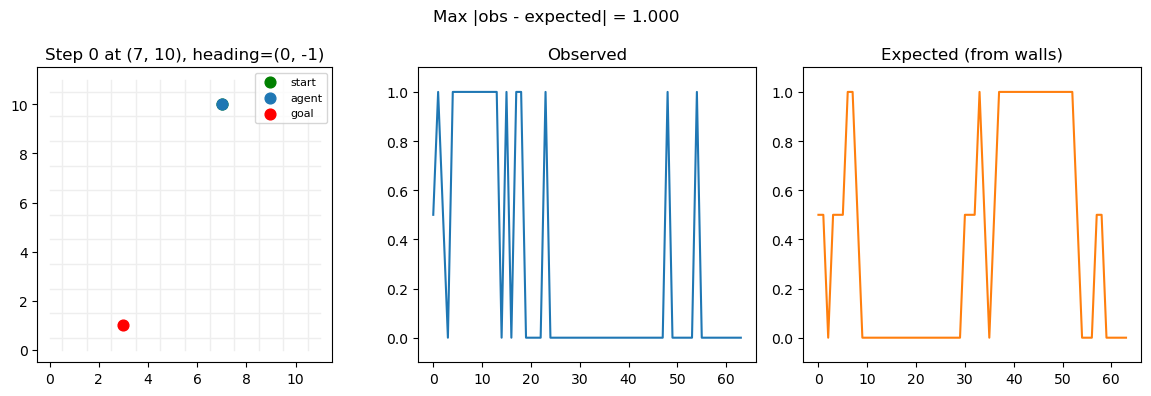

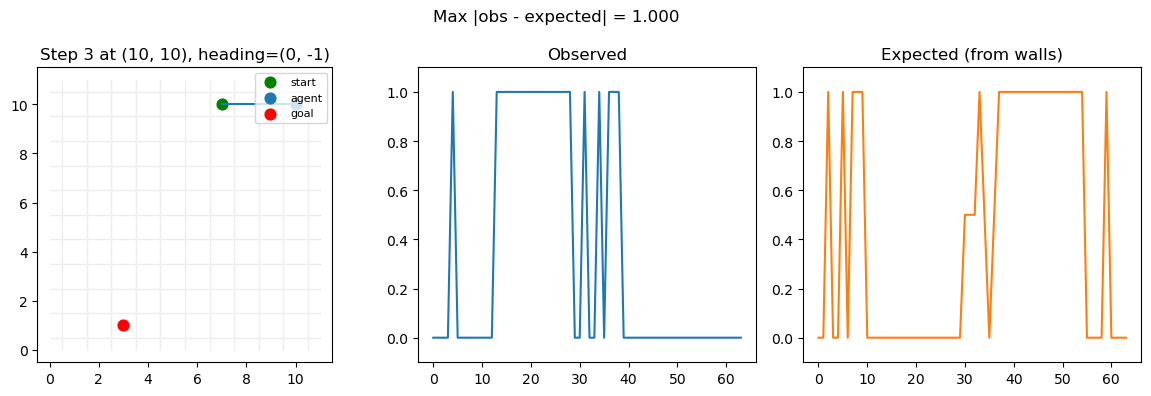

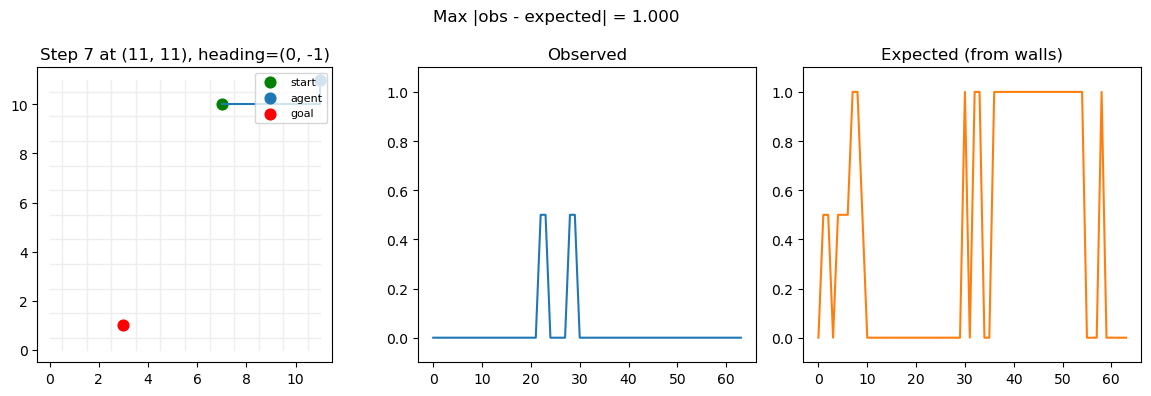

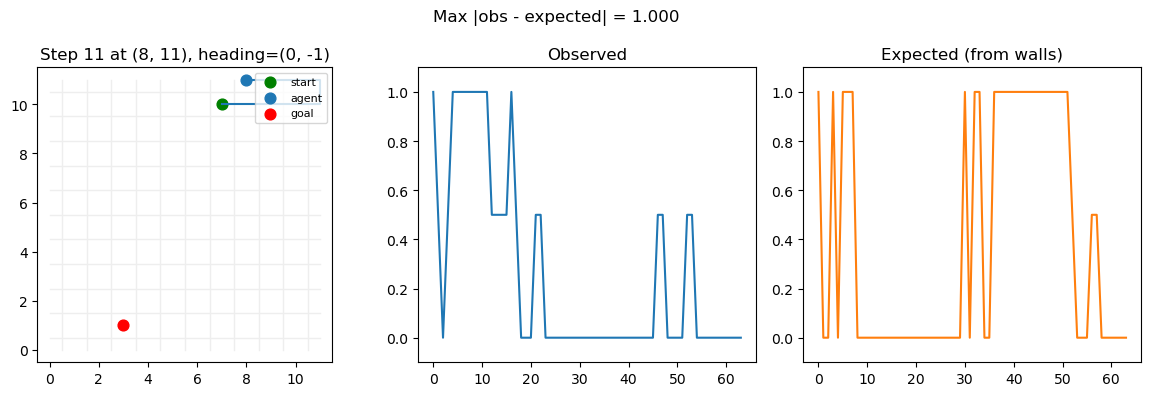

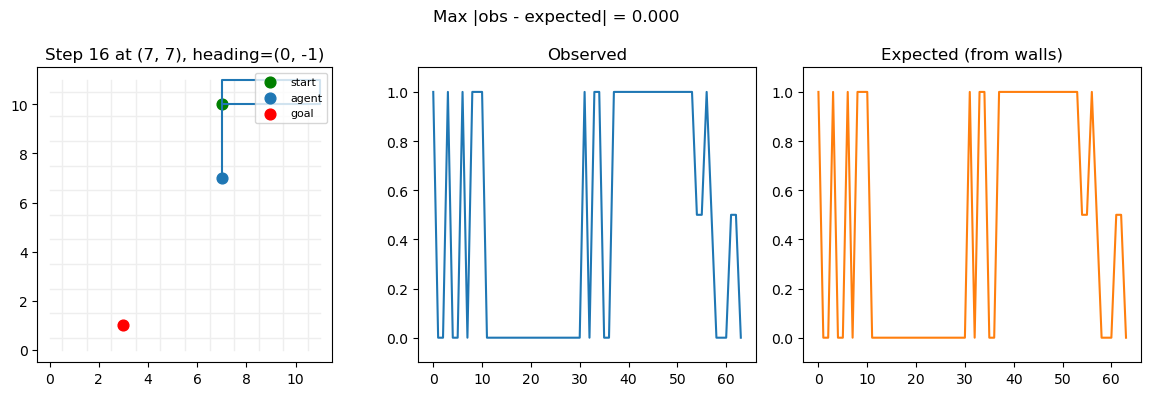

In [1]:
# Visualize an agent navigating WMEnv and what it "sees" vs what it "should" see.
# Paste this into a notebook cell and run.

import numpy as np
import matplotlib.pyplot as plt
from typing import Tuple, List
from cls import WMEnv

# Geometry → segment counts (left, front, right)
def counts_from_geometry(size: int, pos: Tuple[int,int], heading: Tuple[int,int], fov_deg: float, observation_size: int):
    x, y = pos
    n, s, e, w = (size - 1) - y, y, (size - 1) - x, x
    if heading == (0, 1):   fdist, ldist, rdist = n, w, e
    elif heading == (0, -1): fdist, ldist, rdist = s, e, w
    elif heading == (1, 0):  fdist, ldist, rdist = e, n, s
    else:                    fdist, ldist, rdist = w, s, n

    half = np.deg2rad(fov_deg / 2.0)
    comp = np.deg2rad(90.0 - fov_deg / 2.0)
    y_extent = fdist * np.tan(half)
    left_from_front  = (y_extent - ldist) * np.tan(comp) if ldist < y_extent else None
    right_from_front = (y_extent - rdist) * np.tan(comp) if rdist < y_extent else None

    front_length = max(0.0, y_extent)
    left_length  = abs(left_from_front)  if left_from_front  is not None else 0.0
    right_length = abs(right_from_front) if right_from_front is not None else 0.0
    vision_length = front_length + left_length + right_length

    if vision_length <= 0:
        front_count, left_count, right_count = observation_size, 0, 0
    else:
        front_count = int(round(observation_size * (front_length / vision_length)))
        left_count  = int(round(observation_size * (left_length  / vision_length)))
        right_count = observation_size - front_count - left_count
        if right_count < 0:
            right_count = 0
    return left_count, front_count, right_count

def slice_centered(pattern: List[int], center_idx: int, count: int, size: int) -> List[int]:
    if count <= 0:
        return []
    half = (count - 1) // 2
    lo = max(0, center_idx - half)
    hi = min(size, lo + count)
    if hi - lo < count:
        lo = max(0, hi - count)
    return pattern[lo:hi]

def walls_and_centers(env: WMEnv, pos: Tuple[int,int], heading: Tuple[int,int]):
    x, y = pos
    if heading == (0, 1):   # north
        return (env._walls.west, y), (env._walls.north, x), (env._walls.east, y)
    if heading == (0, -1):  # south
        return (env._walls.east, y), (env._walls.south, x), (env._walls.west, y)
    if heading == (1, 0):   # east
        return (env._walls.north, x), (env._walls.east, y), (env._walls.south, x)
    # west
    return (env._walls.south, x), (env._walls.west, y), (env._walls.north, x)

def expected_obs(env, pos, heading):
    lc, fc, rc = counts_from_geometry(env.size, pos, heading, env._fov_deg, env._observation_size)

    def resample_centered(pattern, center_idx, count, size):
        if count <= 0: return []
        if count == 1:
            idx = max(0, min(size-1, center_idx))
            return [float(pattern[idx])]
        half = (count - 1) / 2.0
        start, end = center_idx - half, center_idx + half
        out = []
        for i in range(count):
            posf = start + (end - start) * (i / (count - 1)) if count > 1 else center_idx
            if posf <= 0: out.append(float(pattern[0])); continue
            if posf >= size - 1: out.append(float(pattern[size - 1])); continue
            i0 = int(np.floor(posf)); i1 = i0 + 1; t = posf - i0
            out.append(float((1 - t) * pattern[i0] + t * pattern[i1]))
        return out

    (l_pat, l_center), (f_pat, f_center), (r_pat, r_center) = walls_and_centers(env, pos, heading)
    left  = resample_centered(l_pat, l_center, lc, env.size)
    front = resample_centered(f_pat, f_center, fc, env.size)
    right = resample_centered(r_pat, r_center, rc, env.size)
    obs_vec = left + front + right
    if len(obs_vec) < env._observation_size:
        obs_vec += [float(obs_vec[-1] if obs_vec else 0.0)] * (env._observation_size - len(obs_vec))
    elif len(obs_vec) > env._observation_size:
        obs_vec = obs_vec[: env._observation_size]
    return obs_vec

def plot_step(env: WMEnv, positions: List[Tuple[int,int]], step_idx: int, obs_vec: List[float], exp_vec: List[float]):
    pos = positions[step_idx]
    goal = env.goal_location
    heading = env.heading

    fig = plt.figure(figsize=(12, 4))
    gs = fig.add_gridspec(1, 3, width_ratios=[1.1, 1, 1])
    ax0 = fig.add_subplot(gs[0, 0])
    ax1 = fig.add_subplot(gs[0, 1])
    ax2 = fig.add_subplot(gs[0, 2])

    # Grid and path
    xs = [p[0] for p in positions[:step_idx+1]]
    ys = [p[1] for p in positions[:step_idx+1]]
    for i in range(env.size + 1):
        ax0.plot([0, env.size - 1], [i - 0.5, i - 0.5], color="#eeeeee", linewidth=1)
        ax0.plot([i - 0.5, i - 0.5], [0, env.size - 1], color="#eeeeee", linewidth=1)
    ax0.plot(xs, ys, color="tab:blue")
    ax0.scatter([xs[0]], [ys[0]], color="green", s=60, label="start")
    ax0.scatter([pos[0]], [pos[1]], color="tab:blue", s=60, label="agent")
    ax0.scatter([goal[0]], [goal[1]], color="red", s=60, label="goal")
    ax0.set_xlim(-0.5, env.size - 0.5)
    ax0.set_ylim(-0.5, env.size - 0.5)
    ax0.set_aspect('equal', adjustable='box')
    ax0.set_title(f"Step {step_idx} at {pos}, heading={heading}")
    ax0.legend(loc="upper right", fontsize=8)

    # Observed vs expected vectors
    obs_arr = np.array(obs_vec, dtype=float)
    exp_arr = np.array(exp_vec, dtype=float)
    ax1.plot(obs_arr, color="tab:blue")
    ax1.set_title("Observed")
    ax1.set_ylim(min(0, obs_arr.min(), exp_arr.min()) - 0.1, max(obs_arr.max(), exp_arr.max()) + 0.1)

    ax2.plot(exp_arr, color="tab:orange")
    ax2.set_title("Expected (from walls)")
    ax2.set_ylim(ax1.get_ylim())

    fig.suptitle(f"Max |obs - expected| = {np.max(np.abs(obs_arr - exp_arr)):.3f}")
    plt.tight_layout()
    plt.show()

def demo_episode():
    # Build env and a short path
    env = WMEnv(size=12, speed=1, seed=42, observation_size=64, fov_deg=120.0)
    actions = [(1,0)]*4 + [(0,1)]*4 + [(-1,0)]*4 + [(0,-1)]*4
    positions = []
    obs_list = []

    cur, goal, obs = env.reset()
    positions.append(cur)
    obs_list.append(obs)

    for a in actions:
        cur, goal, obs = env.step(a)
        positions.append(cur)
        obs_list.append(obs)

    # Show a few representative steps
    for step_idx in [0, 3, 7, 11, len(positions)-1]:
        pos = positions[step_idx]
        heading = env.heading if step_idx == len(positions)-1 else env.heading  # current heading; step-level heading is retained
        expected = expected_obs(env, pos, heading)
        plot_step(env, positions, step_idx, obs_list[step_idx], expected)

# Run the demo
demo_episode()